# 1. "A quantidade de pedido mensal segue um padrão sazonal"

## Importação de bibliotecas

In [1]:
from scipy import stats
import scipy
import scipy.fftpack

import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Leitura dos dados

In [2]:
orders = pd.read_csv("../datasets/trusted/delivered_orders.csv")
orders.count()

Unnamed: 0                       93011
order_id                         93011
customer_id                      93011
order_approved_at                92997
order_purchase_timestamp         93011
order_estimated_delivery_date    93011
order_delivered_carrier_date     93009
order_delivered_customer_date    93003
dtype: int64

In [3]:
purchase_time = pd.to_datetime(orders['order_purchase_timestamp'])

orders_by_year_and_month = pd.DataFrame({
        'id': orders['order_id'],
        'time': pd.to_numeric(purchase_time),
        'year': purchase_time.dt.year,
        'month': purchase_time.dt.month,
        'day': purchase_time.dt.day,
})
orders_by_year_and_month.count()

id       93011
time     93011
year     93011
month    93011
day      93011
dtype: int64

In [4]:
orders_by_day = orders_by_year_and_month.groupby(['year', 'month', 'day']).agg(['count'])
orders_by_day.head()

id  time
               count count
year month day            
2017 1     5      32    32
           6       4     4
           7       4     4
           8       4     4
           9       5     5

## Análise por mês

A hipótese era de que haveria um padrão sazonal entre a quantidade de compras por mês no ano.


### Método

Dividimos os dados por mês, para ter uma visão geral da quantidade de compras mensal ao longo do ano.

Para ter uma noção mais relevante da sazonalidade dos dados, usamos [Transformadas de Fourier](https://pt.wikipedia.org/wiki/Transformada_de_Fourier) para encontrar as frequências mais relevantes no conjunto de dados.

Para isso aplicamos a função [`np.fft.rfft`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.fft.rfft.html) do NumPy, que usa Fast Fourier Transform em sequências reais 1-D e elimina informações redundantes (simetria).

Também analisamos os dados usando a frequência relativa de compras, de forma semelhante a uma [Estimativa de densidade kernel (KDE)](https://pt.wikipedia.org/wiki/Estimativa_de_densidade_kernel). Desse modo, poderiamos analisar se os dados se distribuíam da mesma forma, independente do crescimento da empresa

Para obtermos uma métrica de sazonalidade, usamos também o [Teste de Kruskal-Wallis](https://pt.wikipedia.org/wiki/Teste_de_Kruskal-Wallis), o qual nos permite comparar dados de diferentes populações e observar se eles possuem a mesma função de distribuição.

#### Sazonalidade dentro do ano

Aqui consideramos cortar os dados para olhar apenas os meses entre Janeiro e Agosto, porque 2018 não tem dados além disso. Chegamos à conclusão, porém, de que usar mais dados em 2017 não afeta a análise.

In [5]:
valid_on_both_years = orders_by_year_and_month #[orders_by_year_and_month['month'] <= 8]

sales_by_month = valid_on_both_years.groupby(['year', 'month']).agg(['count']).reset_index()
sales_by_month.describe()

,year,month,id,time,day
,,,count,count,count
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2017.400000,5.700000,4650.550000,4650.550000,4650.550000
std,0.502625,3.278318,1944.153191,1944.153191,1944.153191
min,2017.000000,1.000000,731.000000,731.000000,731.000000
25%,2017.000000,3.000000,3339.000000,3339.000000,3339.000000
50%,2017.000000,5.500000,4842.500000,4842.500000,4842.500000
75%,2018.000000,8.000000,6424.500000,6424.500000,6424.500000
max,2018.000000,12.000000,7070.000000,7070.000000,7070.000000


In [6]:
sales_2017 = sales_by_month[sales_by_month['year'] == 2017]['id']['count']

fourier_2017 = np.abs(np.fft.rfft(sales_2017))
fourier_2017

array([42119.        ,  9213.03292432,  6815.17255834,  5811.77399767,
        4628.01004753,  1892.81862189,   857.        ])

In [7]:
sales_2018 = sales_by_month[sales_by_month['year'] == 2018]['id']['count']

fourier_2018 = np.abs(np.fft.rfft(sales_2018))
fourier_2018

array([50892.        ,  1652.65748583,   837.0818359 ,   302.81221003,
        1122.        ])

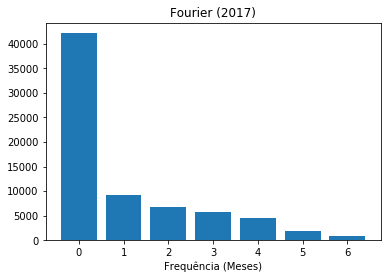

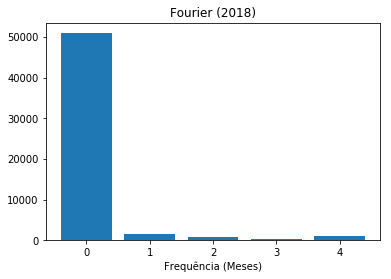

In [8]:
plt.bar(range(len(fourier_2017)), fourier_2017)
plt.title("Fourier (2017)")
plt.xlabel("Frequência (Meses)")
plt.show()

plt.bar(range(len(fourier_2018)), fourier_2018)
plt.title("Fourier (2018)")
plt.xlabel("Frequência (Meses)")
plt.show()

In [9]:
print(stats.kruskal(fourier_2017, fourier_2018).pvalue * 100, "%", sep='')

16.746459631208534%


Como a frequência mais relevante dada pelo Fourier em ambos os anos é 0, podemos deduzir que não existe sazonalidade dentro de um ano, ou que ela é praticamente nula.

In [10]:
data_2017 = orders_by_year_and_month.groupby(['year']).get_group(2017)['month']

kde_2017 = np.histogram(data_2017, density=True, bins=range(13))[0]
kde_2017

array([0.        , 0.01735559, 0.03817754, 0.05845343, 0.05273155,
       0.08157839, 0.07236639, 0.08986443, 0.09660723, 0.09506399,
       0.10230537, 0.29549609])

In [11]:
data_2018 = orders_by_year_and_month.groupby(['year']).get_group(2018)['month']

kde_2018 = np.histogram(data_2018, density=True, bins=range(13))[0]
kde_2018

array([0.        , 0.13491315, 0.1257958 , 0.13277136, 0.12862532,
       0.12756425, 0.11432052, 0.11577458, 0.12023501, 0.        ,
       0.        , 0.        ])

In [12]:
print(stats.kruskal(kde_2017, kde_2018).pvalue * 100, "%", sep='')

29.658785284177707%


Observando os dados de frequência relativa de 2017, percebemos que a maior parte das compras se concentra no final do ano, e desse modo não conseguimos compará-lo ao ano de 2018, em que as compras estão melhor distribuídas. Acreditamos que isso se dê pois a empresa provavelmente teve um grande crescimento no ano de 2017 e portanto, nosso pressuposto de que a média das compras se mantém durante o ano é falso, tornando nossa análise inválida e possivelmente justificando a baixa sazonalidade observada.

#### Sazonalidade mensal

In [13]:
sales_by_month = orders_by_year_and_month.groupby(['year', 'month']).agg(['count']).reset_index()
sales_by_month.describe()

,year,month,id,time,day
,,,count,count,count
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2017.400000,5.700000,4650.550000,4650.550000,4650.550000
std,0.502625,3.278318,1944.153191,1944.153191,1944.153191
min,2017.000000,1.000000,731.000000,731.000000,731.000000
25%,2017.000000,3.000000,3339.000000,3339.000000,3339.000000
50%,2017.000000,5.500000,4842.500000,4842.500000,4842.500000
75%,2018.000000,8.000000,6424.500000,6424.500000,6424.500000
max,2018.000000,12.000000,7070.000000,7070.000000,7070.000000


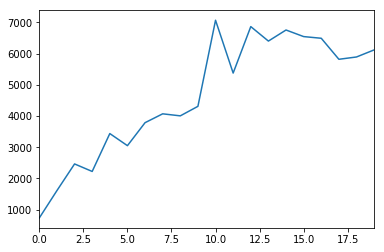

In [14]:
sales_by_month['id']['count'].plot()

In [15]:
fourier_all = np.abs(np.fft.rfft(sales_by_month['id']['count']))
fourier_all

array([93011.        , 22779.00867959,  5561.92498433,  6572.24643133,
        3130.26267431,  5439.14377453,  2687.76905048,  6240.10341329,
        3080.06941315,  5305.23042029,  1979.        ])

<BarContainer object of 11 artists>

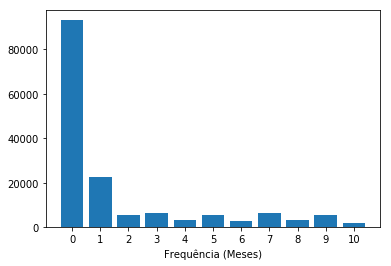

In [16]:
plt.xticks(range(len(fourier_all)))
plt.xlabel("Frequência (Meses)")
plt.bar(range(len(fourier_all)), fourier_all)

Assim como na análise anterior, pode-se notar que a frequência mais relevante é 0, o que indica ausência de uma sazonalidade forte também no período dos 20 meses observados.

### Conclusão

Olhando para os gráficos gerados para as transformações de fourier dos números de pedidos nos dois anos e nos 20 meses disponíveis, percebemos que não existe nenhum tipo de sazonalidade no número de pedidos dentro de um ano ou desse período, visto que apesar de algumas frequências se destacarem, como o período de 1 mês no último gráfico, a frequência 0 é predominante.


### Problema

Como descobrimos com o Luan, a quantidade de dados (só 16 pontos, jan-ago 2017 e jan-ago 2018) usadas para essa análise foi muito pequena, de forma que o método da transformação rápida de fourier não consegue fazer uma aproximação da função que descreve a variação de compras por mês.

A alternativa levantada foi, então, usar dados diários ao invés de mensais.

## Análise por dia

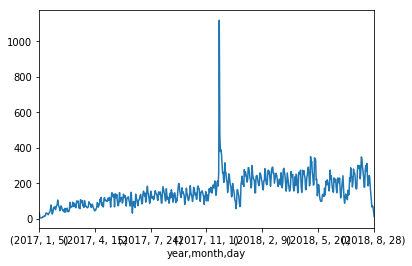

In [17]:
orders_by_day['id']['count'].plot()

In [18]:
print(orders_by_day['id']['count'].idxmax())

(2017, 11, 24)


O dia com maior volume de compras foi o dia 24/11/2017, curiosamente uma Black Friday.

In [19]:
orders_by_day = orders_by_day.reset_index()

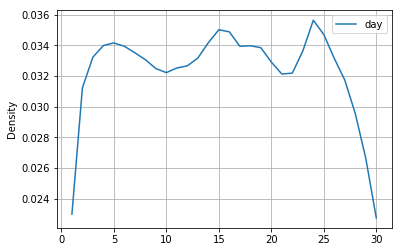

In [20]:
orders_by_year_and_month.plot.kde(y='day', ind=range(1, 31), grid=True)

Em termos gerais, nota-se uma maior concentração de compras por volta dos dias 5, 15 e 24.

A concentração elevada no dia 24 provavelmente ocorre por conta do dia 24/11/2017, que teve um volume anormal de compras. Removendo os dados desse mês, nota-se que o pico desaparece.

In [21]:
black_friday = orders_by_year_and_month[orders_by_year_and_month['month'] == 11]
black_friday.count()

id       7070
time     7070
year     7070
month    7070
day      7070
dtype: int64

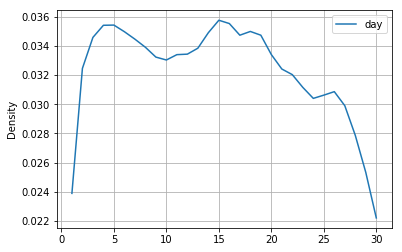

In [22]:
filtered = orders_by_year_and_month[~orders_by_year_and_month.isin(black_friday)]
filtered.plot.kde(y='day', ind=range(1, 31), grid=True)

### Por mês

In [23]:
orders_by_day_by_month = orders_by_year_and_month.groupby(['year', 'month'])

def histogram_for_month(m):
    days = orders_by_day_by_month.get_group(m)['day']
    return np.histogram(days, density=True, bins=range(32))[0]

monthly = [histogram_for_month(m) for m in orders_by_day_by_month.groups]
len(monthly)

20

In [24]:
def month_name(m):
    return datetime.date(1900, m % 12 + 1, 1).strftime('%B')

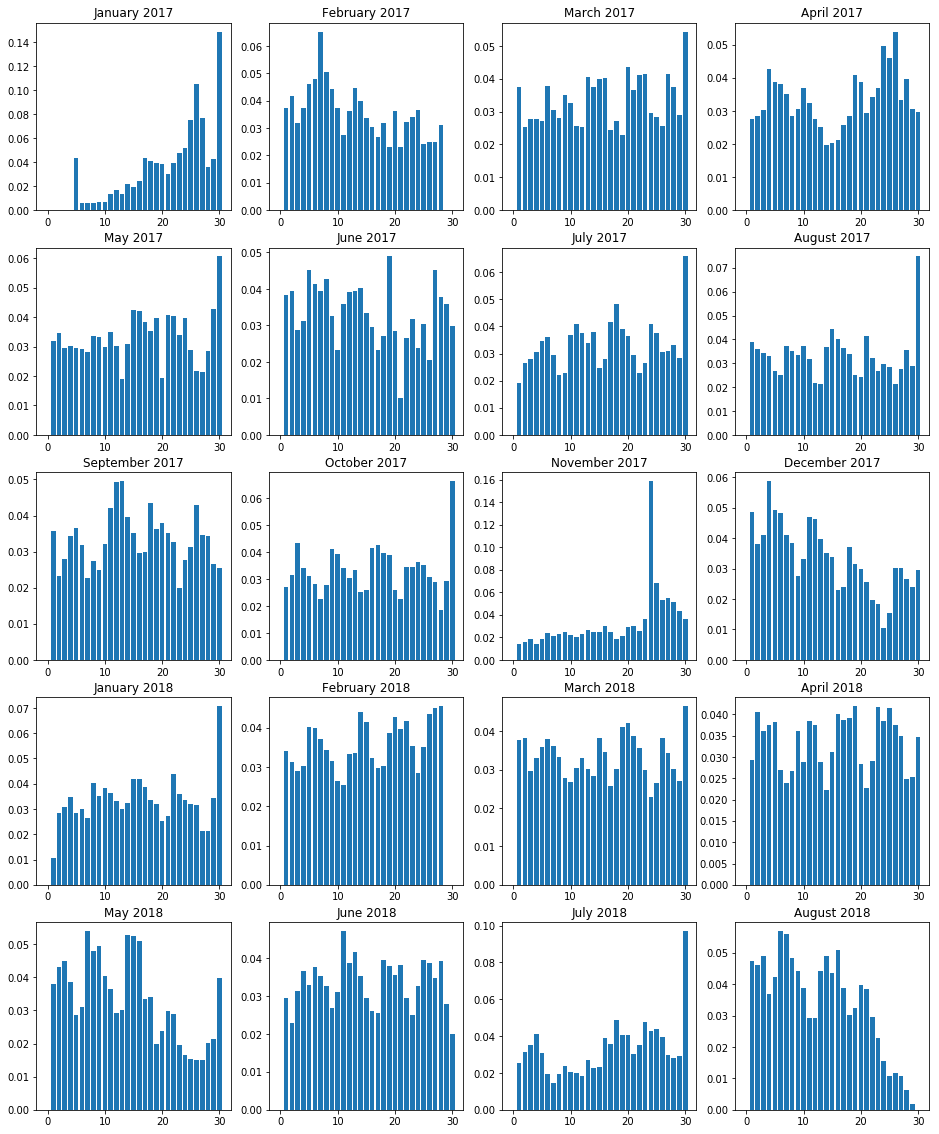

In [25]:
plt.figure(figsize=(16, 20))
plt.tight_layout()

for m in range(len(monthly)):
    plt.subplot(5, 4, m + 1)
    month = monthly[m]
               
    plt.title(month_name(m) + ' ' + str(2017 + m // 12))
    plt.bar(range(len(month)), month)
    
plt.show()

#### P-value para o kruskal das distrubuições de compras por dia dos mesmos meses entre os anos

In [26]:
print("P-Value:")
for m in range(len(monthly) - 12):
    month = monthly[m]
    aux_month = monthly[m + 12]
    
    pvalue = stats.kruskal(month, aux_month).pvalue
    print("\t", month_name(m), ":    \t", pvalue * 100, "%", sep='')

P-Value:
	January:    	49.004245412972416%
	February:    	79.98419637177668%
	March:    	73.54075855847017%
	April:    	84.37201218298358%
	May:    	94.38781459053033%
	June:    	81.08101883942803%
	July:    	71.43020983313252%
	August:    	26.296882868819537%


O valor é alto para a maioria dos meses, indicando alta probabilidade de que a distribuição nas vendas para os mesmos meses entre os dois anos é parecida.

Os valores baixos nos meses de janeiro e agosto provavelmente ocorrem pela falta de dados em Janeiro de 2017 e Agosto de 2018.

#### P-Value para o Kruskal das distribuições de compras por dia entre cada mês

In [46]:
orders_by_day_by_month = orders_by_year_and_month.groupby(['year', 'month'])
monthly = [histogram_for_month(m) for m in orders_by_day_by_month.groups]

print(stats.kruskal(*monthly).pvalue * 100, "%", sep='')

87.47727654472787%


O p-value de ~87.5% indica uma alta probabilidade de que a distribuição para as vendas entre os dias de todos os meses é a mesma.

Se agruparmos os meses iguais nos dois anos, no entanto, temos um resultado bastante diferente:

In [47]:
orders_by_day_by_month = orders_by_year_and_month.groupby(['month'])
monthly = [histogram_for_month(m) for m in orders_by_day_by_month.groups]

print(stats.kruskal(*monthly).pvalue * 100, "%", sep='')

37.32546380118267%


O p-value abaixo de 40% indica uma baixa probabilidade de a distribuição das vendas por dia nos meses, sem contar meses repetidos, serem a mesma.

#### Transformação de Fourier para as distribuições de compras em cada mês

In [48]:
orders_by_day_by_month = orders_by_year_and_month.groupby(['year', 'month'])
monthly = [histogram_for_month(m) for m in orders_by_day_by_month.groups]

populations = [np.abs(np.fft.rfft(monthly[m])[1:]) for m in range(len(monthly))]
len(populations)

20

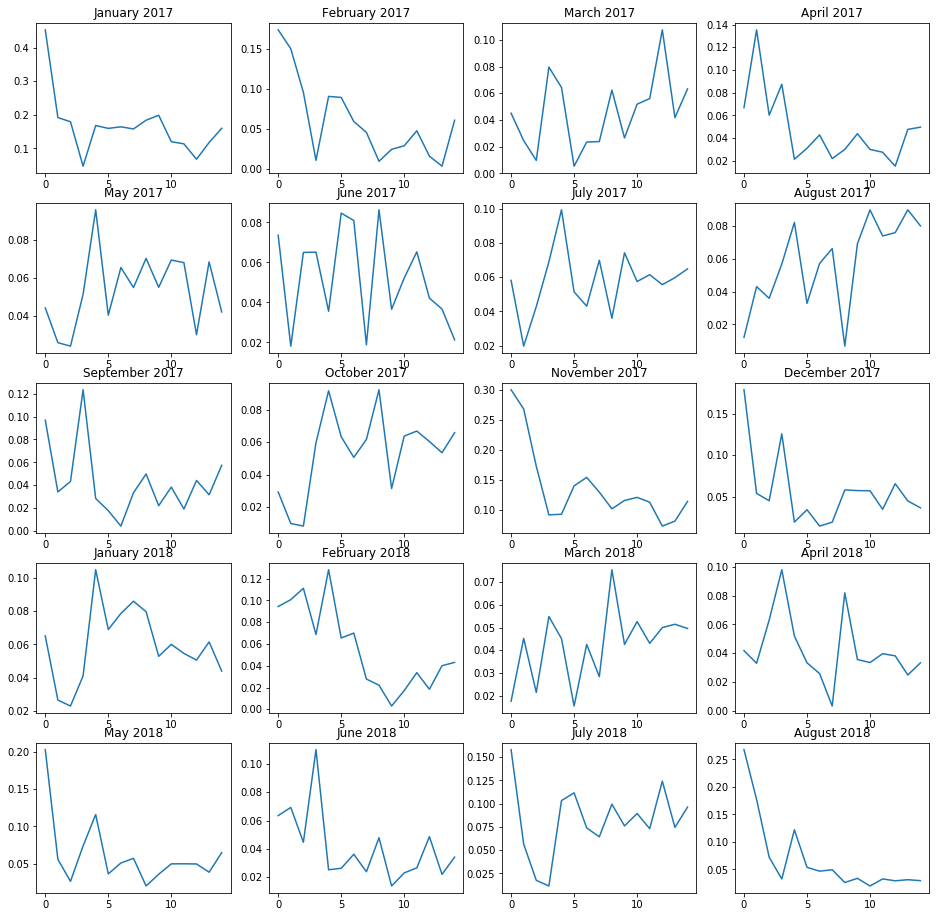

In [49]:
plt.figure(figsize=(16, 16))

plt.title("Fourier por dia do mês")
plt.xlabel("Frequência (Dias)")
plt.ylabel("Amplitude")

for p in range(len(populations)):
    plt.subplot(5, 4, p + 1)
    plt.title(month_name(p) + ' ' + str(2017 + p // 12))
    plt.plot(populations[p])
    
plt.show()

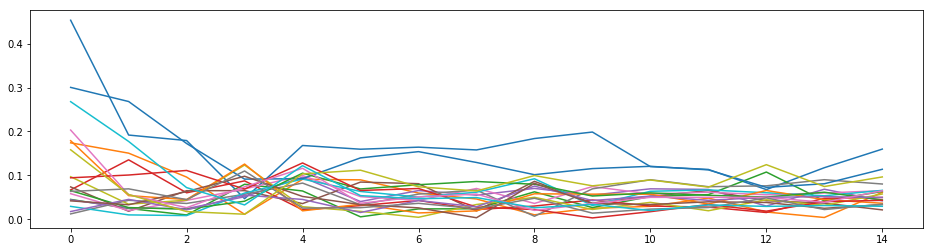

In [50]:
plt.figure(figsize=(16, 4))

for p in populations:
    plt.plot(p)

In [51]:
print("P-Value: ", stats.kruskal(*populations).pvalue * 100, "%", sep='')

P-Value: 2.997403451429118e-08%


### Por ano

In [52]:
orders_by_day_2017 = orders_by_day[
    (orders_by_day['year'] == 2017) &
    (orders_by_day['month'] <= 8)
]['id']['count']
orders_by_day_2017.describe()

count    239.000000
mean      89.372385
std       38.726137
min        4.000000
25%       63.000000
50%       90.000000
75%      117.000000
max      183.000000
Name: count, dtype: float64

In [53]:
orders_by_day_2018 = orders_by_day[
    (orders_by_day['year'] == 2018) &
    (orders_by_day['month'] <= 8)
]['id']['count']
orders_by_day_2018.describe()

count    241.000000
mean     211.170124
std       58.756419
min       11.000000
25%      178.000000
50%      217.000000
75%      251.000000
max      350.000000
Name: count, dtype: float64

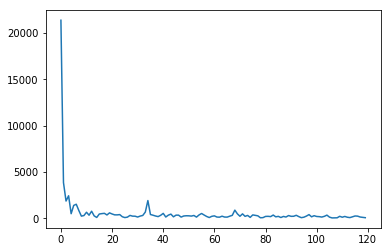

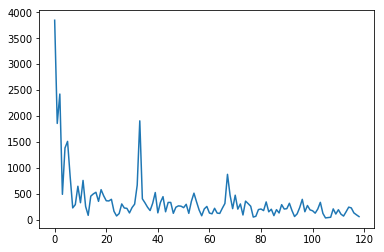

0

In [54]:
fourier_2017 = np.abs(np.fft.rfft(orders_by_day_2017))

plt.plot(fourier_2017)
plt.show()

plt.plot(fourier_2017[1:])
plt.show()

fourier_2017.argmax()

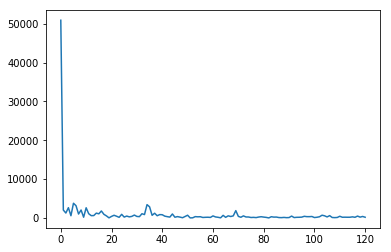

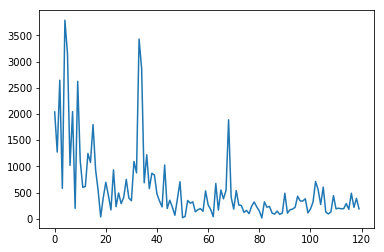

0

In [55]:
fourier_2018 = np.abs(np.fft.rfft(orders_by_day_2018))
fourier_2018

plt.plot(fourier_2018)
plt.show()

plt.plot(fourier_2018[1:])
plt.show()

fourier_2018.argmax()

In [61]:
print("P-Value: ", stats.kruskal(fourier_2017, fourier_2018).pvalue * 100, '%', sep='')

P-Value: 0.2366224117296674%
